# 06C. SDE integrators

### Mingyang Lu

### 3/7/2024

# Brownian dynamics revisit

We have simulated the Brownian motion by the model of random walk, where we find $<x>=0$ and $<x^2> \sim t$. These statistical properties allow us to describe the Brownian motion by a continuous time stochastic process, called Wiener process. This mathematical framework can be generalized to describe some other stochastic processes using stochastic differential equations (SDEs):

$$dX = f(X)dt + \sqrt{2D(X)}dW \tag{1}$$

Here, $W$ a Wiener process (continuous-time stochastic process, see the previous note *brownian.Rmd*). $f(x)$ is the derivative function, the same as what we have used in an ODE. $D(X)$ is the state-dependent diffusion coefficient (not a constant anymore) and represents the level of noises.

In physics there is another way to describe a stochastic process by a Langevin equation: 

$$\frac{dX}{dt} = f(X) + \sqrt{2D(X)}\eta(t) \tag{2}$$
,where $\eta(t)$ is a noise term. The most common type of noise is Gaussian white noise, which by definition is a random signal having equal intensity at different frequencies. $\eta(t)$ of a Gaussian white noise (essentially a Gaussian probability distribution) satisfies

\begin{equation}
\begin{cases} <\eta(t)> = 0  \\
              <\eta(t)\eta(t')> = \delta (t-t')  \tag{3} \end{cases}
\end{equation}

Here, the symbol $<.>$ means the average operation. $<\eta(t)\eta(t')>$ is a correlation function ([see here for more details](https://en.wikipedia.org/wiki/Correlation_function_(statistical_mechanics))), and \delta (t-t') is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function) of $t-t'$. $\delta (t-t')$ is normalized, and it is nonzero only when $t-t'$ approaches to zero. $\eta(t)$ of a Gaussian white noise is closely related to the Wiener process.

# Euler–Maruyama method

We can numerically solve the SDE in Equation (1) by

$$X_{n+1} = X_n + f(X_n)\Delta t + \sqrt{2D(X_n)} \Delta W_n \tag{4}$$
$\Delta W_n$ represents normal random variables with mean zero and variance $\Delta t$. ($<\Delta W_n^2> = \Delta t$) This is called Euler-Maruyama method, an extension of the Euler method for ODEs to SDEs. Now, we show the implementation in R. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def SDE_Euler(derivs, noise, t0, X0, t_total, dt, **kwargs):
    """
    Euler-Maruyama method for one-variable SDE
    :param derivs: function of the derivatives
    :param noise: function of the noise term
    :param t0: initial time
    :param X0: initial condition
    :param t_total: total simulation time
    :param dt: time step size
    :param **kwargs: additional keyworded arguments to derivs and noise functions
    :return: matrix of t & X(t) for all time steps
    """
    t_all = np.arange(t0, t_total + dt, dt)
    n_all = len(t_all)
    X_all = np.zeros(n_all)
    X_all[0] = X0
    dW_all = np.random.normal(loc=0, scale=np.sqrt(dt), size=n_all - 1)  # all dW terms

    for i in range(n_all - 1):
        t = t_all[i]
        X = X_all[i]
        X_all[i + 1] = X + dt * derivs(t, X, **kwargs) + dW_all[i] * noise(t, X, **kwargs)

    return np.column_stack((t_all, X_all))  # the output is a matrix of t & X(t) for all time steps

Note that in the implementation, all random variables $\Delta W$ are generated altogether. This step is more efficient in R, compared to the way to generate them in each step. However, it requires a lot more memory to do so, therefore not ideal for long simulations. The best approach is to use compiled functions with Fortran and C.

A common mistake by a beginner is to add $\sqrt{2D(X)}$ to the $f(X)$ term and integrate with the ODE version of the Euler method. This is wrong, as the variance of the random variables is now $\Delta t^2$ instead of $\Delta t$. 

Now we will apply the Euler-Maruyama method to a few SDEs. We first consider a simple Brownian motion, where $f(X) = 0$.

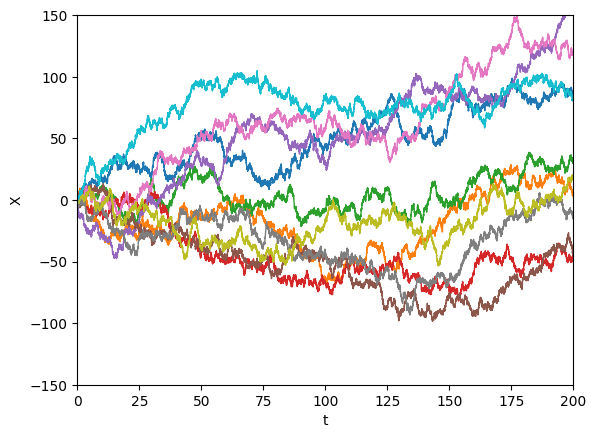

In [2]:
def f_bm(t, X, D):
    return 0

def noise_bm(t, X, D):
    return np.sqrt(2 * D)

np.random.seed(1)

plt.figure()
plt.xlabel('t')
plt.ylabel('X')

plt.xlim(0, 200)
plt.ylim(-150, 150)

for i in range(10):
    results = SDE_Euler(derivs=f_bm, noise=noise_bm, t0=0, X0=0, t_total=200, dt=0.01, D=10)
    plt.plot(results[:, 0], results[:, 1], linewidth=1)

plt.show()

The integration of the SDE gives the same results as our previous simulations of the Brownian motion.

Let's consider another example: Brownian dynamics under a harmonic potential and constant noise. Here, the Brownian particle is tethered to a spring. According to Hooke's law, $f(X) = - kX$. $k$ is the spring constant. This type of system is also called Ornstein–Uhlenbeck process. 

$$dX = -kXdt + \sqrt{2D}dW \tag{5}$$

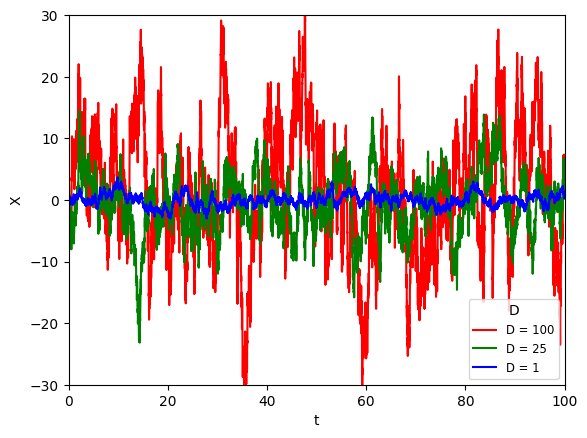

In [3]:
def f_ou(t, X, k, D):
    return -k * X

def noise_ou(t, X, k, D):
    return np.sqrt(2 * D)

np.random.seed(1)  # Students can try different RNG seed
D_all = [100, 25, 1]

results1 = SDE_Euler(derivs=f_ou, noise=noise_ou, t0=0, X0=0, t_total=1000, dt=0.01, k=1, D=D_all[0])
results2 = SDE_Euler(derivs=f_ou, noise=noise_ou, t0=0, X0=0, t_total=1000, dt=0.01, k=1, D=D_all[1])
results3 = SDE_Euler(derivs=f_ou, noise=noise_ou, t0=0, X0=0, t_total=1000, dt=0.01, k=1, D=D_all[2])

plt.figure()
plt.xlabel('t')
plt.ylabel('X')
plt.xlim(0, 100)
plt.ylim(-30, 30)

plt.plot(results1[:, 0], results1[:, 1], color='red', label='D = ' + str(D_all[0]))
plt.plot(results2[:, 0], results2[:, 1], color='green', label='D = ' + str(D_all[1]))
plt.plot(results3[:, 0], results3[:, 1], color='blue', label='D = ' + str(D_all[2]))

plt.legend(loc='lower right', title='D', fontsize='small')
plt.show()

In the above simulations, we plot the stochastic dynamics for three different noise levels. Unlike the Brownian motion, the dynamics of $X$ fluctuate around 0 with deviations proportional to the noise level $D$. The larger the $D$, the noisier the $X$ is: $<x^2>=\frac{D}{k}$.

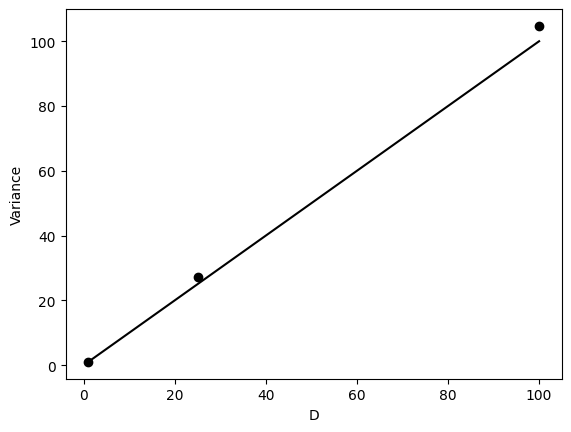

In [4]:
D_all = [100, 25, 1]

variances = [np.var(results1[:, 1]), np.var(results2[:, 1]), np.var(results3[:, 1])]

plt.scatter(D_all,variances, color='black')
plt.xlabel('D')
plt.ylabel('Variance')
plt.plot(D_all, D_all, color='black', linestyle='-') 
plt.show()

In the above test, we find that the simulation results still slightly deviate from the theoretical values. That is because the simulation is not long enough to reach robust statistics. 

# Milstein method

The Milstein method is a more accurate SDE integrator. Consider an SDE in the following form,

$$dX = f(X)dt + s(X)dW \tag{6}$$
Milstein method integrates SDE by

$$X_{n+1} = X_n + f(X_n)\Delta t + s(X_n) \Delta W_n + \frac{1}{2}s(X_n)s'(X_n)((\Delta W_n)^2-\Delta t) \tag{7}$$

, where $s'$ denotes the derivative of s(X) with respect to $X$. Here, we consider $s(X)=\sqrt{2D(X)}$. The derivation of Equation (1) is by stochastic Taylor expansion. When $D$ is a constant, $s'(X) = 0$. Thus, the Milstein method is equivalent to the Euler-Maruyama method. The Milstein method converges faster than the Euler-Maruyama method for the case in which the noise depends on the state $X$.


In [5]:
def SDE_Milstein(derivs, noise, dnoise, t0, X0, t_total, dt, **kwargs):
    """
    An SDE integrator by the Milstein method
    :param derivs: function of the derivatives
    :param noise: function of the noise term
    :param dnoise: function of the derivative of the noise with respect to X
    :param t0: initial time
    :param X0: initial condition
    :param t_total: total simulation time
    :param dt: time step size
    :param **kwargs: additional keyworded arguments to derivs and noise functions
    :return: matrix of t & X(t) for all time steps
    """
    t_all = np.arange(t0, t_total + dt, dt)
    n_all = len(t_all)
    X_all = np.zeros(n_all)
    X_all[0] = X0
    dW_all = np.random.normal(loc=0, scale=np.sqrt(dt), size=n_all - 1)  # all dW terms

    for i in range(n_all - 1):
        t = t_all[i]
        X = X_all[i]
        s = noise(t, X, **kwargs)
        dW = dW_all[i]
        X_all[i + 1] = X + dt * derivs(t, X, **kwargs) + dW * s + 0.5 * s * dnoise(t, X, **kwargs) * (dW ** 2 - dt)

    return np.column_stack((t_all, X_all))  # the output is a matrix of t & X(t) for all time steps

# Gene expression noise in a gene circuit

We consider a circuit of a self-activating gene $X$ with a noise term $s(X) = b\sqrt{X}$.

$dX = [g_0 + g_1 \frac{(X/X_0)^{n_X}}{1+(X/X_0)^{n_X}} - kX]dt + b\sqrt{X}dW \tag{8}$

In Equation (8), the standard deviation of the noise is proportional to $\sqrt{X}$. The noise level becomes larger for larger $X$. But when $X$ approaches to zero, the noise level is close to zero. A similar SDE has been adopted to model the stochastic evolution of interest rates by the Cox-Ingersoll-Ross model in finance. 


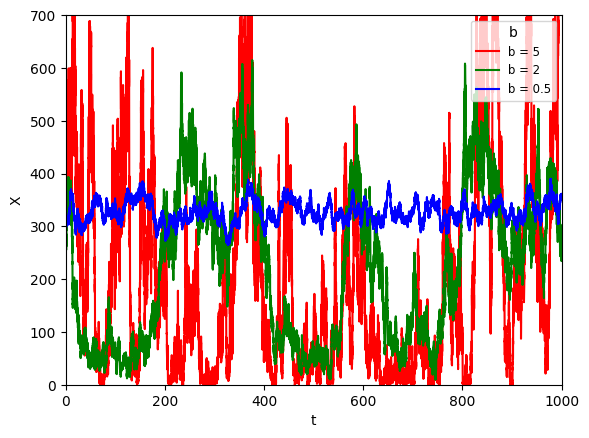

In [6]:
def hill_ex(X, X0, n):
    a = (X / X0) ** n
    return a / (1 + a)

def f_1g(t, X, b):
    return 10 + 45 * hill_ex(X, 200, 4) - 0.15 * X

def noise_1g(t, X, b):
    return b * np.sqrt(X)

def dnoise_1g(t, X, b):
    return b / np.sqrt(X) / 2

b_all = [5, 2, 0.5]
np.random.seed(1)

results1 = SDE_Milstein(derivs=f_1g, noise=noise_1g, dnoise=dnoise_1g, t0=0, X0=300, t_total=1000, dt=0.01, b=b_all[0])
results2 = SDE_Milstein(derivs=f_1g, noise=noise_1g, dnoise=dnoise_1g, t0=0, X0=300, t_total=1000, dt=0.01, b=b_all[1])
results3 = SDE_Milstein(derivs=f_1g, noise=noise_1g, dnoise=dnoise_1g, t0=0, X0=300, t_total=1000, dt=0.01, b=b_all[2])

plt.plot(results1[:, 0], results1[:, 1], color='red')
plt.plot(results2[:, 0], results2[:, 1], color='green')
plt.plot(results3[:, 0], results3[:, 1], color='blue')
plt.xlabel('t')
plt.ylabel('X')
plt.xlim(0, 1000)
plt.ylim(0, 700)
plt.legend(labels=[f'b = {b}' for b in b_all], loc='upper right', title='b', fontsize='small')
plt.show()

The circuit of a self-activating gene has two stable steady states: one near $X = 100$ and the other near $X = 300$. The steady states remains in the stochastic dynamics. One interesting feature of stochastic dynamics of multi-stable systems is dynamical transition between steady states. When the noise is low ($b = 0.5$), $X$ only slightly fluctuates around one stable steady state, and the transition to the other stable steady state is unlikely. When the noise becomes larger ($b = 2$), the circuit dynamics start to exhibit transitions between the two states. When the noise becomes very large ($b = 5$), the state transitions become much frequently. 

Lastly, we consider the same gene circuit but a constant noise. In this case, the Euler-Maruyama method gives the same results as the Milstein method.

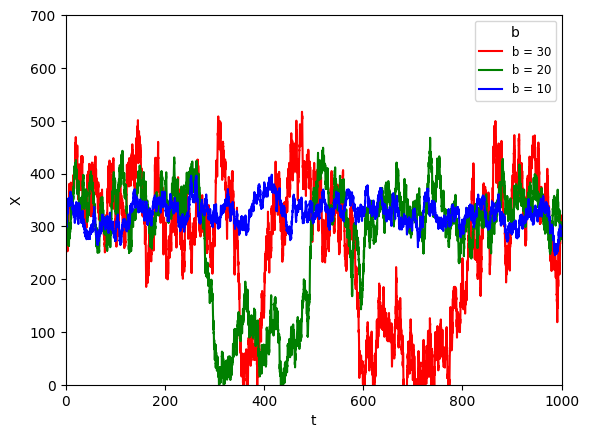

In [7]:
def f_1g(t, X, b):
    return 10 + 45 * hill_ex(X, 200, 4) - 0.15 * X

def hill_ex(X, X0, n):
    a = (X / X0) ** n
    return a / (1 + a)

def noise_1g_2(t, X, b):
    return b

def dnoise_1g_2(t, X, b):
    return 0

b_all = [30, 20, 10]
np.random.seed(1)

results1 = SDE_Milstein(derivs=f_1g, noise=noise_1g_2, dnoise=dnoise_1g_2, t0=0, X0=300, t_total=1000, dt=0.1, b=b_all[0])
results2 = SDE_Milstein(derivs=f_1g, noise=noise_1g_2, dnoise=dnoise_1g_2, t0=0, X0=300, t_total=1000, dt=0.1, b=b_all[1])
results3 = SDE_Milstein(derivs=f_1g, noise=noise_1g_2, dnoise=dnoise_1g_2, t0=0, X0=300, t_total=1000, dt=0.1, b=b_all[2])

plt.plot(results1[:, 0], results1[:, 1], color='red')
plt.plot(results2[:, 0], results2[:, 1], color='green')
plt.plot(results3[:, 0], results3[:, 1], color='blue')
plt.xlabel('t')
plt.ylabel('X')
plt.xlim(0, 1000)
plt.ylim(0, 700)
plt.legend(labels=[f'b = {b}' for b in b_all], loc='upper right', title='b', fontsize='small')
plt.show()


As shown in the above plot, the stochastic dynamics look very different from the previous simulations. (Of course, we are not able to set comparable noise levels for the two cases; thus direct comparison is hard.) However, there are at least two clear differences. 

(1) Compared to the case of the state-dependent noise, the circuit with constant noise has larger $X$ fluctuation around the low expression state and has smaller $X$ fluctuation around the high expression state. 

(2) When the circuit is at the low expression state, high noise would result in $X$ below zero. That is because of the discretization during the SDE integration. Making the time step size $dt$ smaller may help to alleviate this issue. 